## Importación de paquetes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d

from numpy import logical_and as npand
from numpy import logical_or as npor
import matplotlib

from sympy import (symbols, pi, I, E, cos, sin, exp, tan, simplify, expand, factor, collect,
                   apart, cancel, expand_trig, diff, Derivative, Function, integrate, limit,
                   series, Eq, solve, dsolve, Matrix, N, preorder_traversal, Float, solve_linear_system,
                   eye, zeros, lambdify, Symbol,hessian, acos)
from sympy.physics.mechanics import dynamicsymbols, init_vprinting
from sympy.physics.mechanics import ReferenceFrame, Point, LagrangesMethod
from sympy import legendre_poly

## Inicializar espacio de trabajo

In [2]:
init_vprinting()

In [3]:
x, t = symbols('x t')

## Probando Polinomios de Legendre

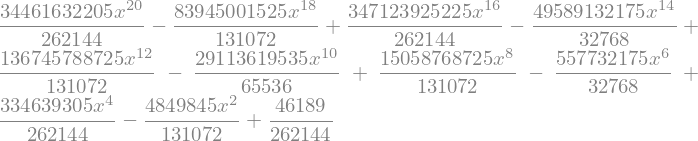

In [4]:
legendre_poly(20)

In [ ]:
N = 100
prec = 20
for ii in legendre_poly(N, polys = True).real_roots():
    print(ii.evalf(n = prec))

In [ ]:
N = 100
prec = 20
for ii in legendre_poly(N, polys = True).diff().real_roots():
    print(ii.evalf(n = prec))

## Funciones que generan N collocation points para esquemas LG, LGR y LGL

In [7]:
def LG(N, precission = 20):
    return [ii.evalf(n = precission) for ii in legendre_poly(N, polys = True).real_roots()]

In [8]:
LG(20,8)

In [9]:
def LGR(N, precission = 20):
    pol = legendre_poly(N, polys = True) + legendre_poly(N-1, polys = True)
    return [ii.evalf(n = precission) for ii in pol.real_roots()]

In [10]:
LGR(6,8)

In [11]:
def LGL(N, precission = 20):
    root_list = [ii.evalf(n = precission) for ii in legendre_poly(N-1, polys = True).diff().real_roots()]
    return [-1.,] + root_list + [1.,]

In [12]:
LGL(7,6)

## Bases de Polinomios de Lagrange

In [13]:
#### CREDIT: https://gist.github.com/folkertdev/084c53887c49a6248839 ####

from operator import mul
from functools import reduce, lru_cache
from itertools import chain

# sympy symbols
x = symbols('x')

# convenience functions
product = lambda *args: reduce(mul, *(list(args) + [1]))


# this product may be reusable (when creating many functions on the same domain)
# therefore, cache the result
@lru_cache(16)
def lag_pol(labels, j):
    def gen(labels, j):
        k = len(labels)
        current = labels[j]
        for m in labels:
            if m == current:
                continue
            yield (x - m) / (current - m)
    return expand(product(gen(labels, j)))


def lagrangePolynomial(xs, ys):
    # based on https://en.wikipedia.org/wiki/Lagrange_polynomial#Example_1
    k = len(xs)
    total = 0

    # use tuple, needs to be hashable to cache
    xs = tuple(xs)

    for j, current in enumerate(ys):
        t = current * lag_pol(xs, j)
        total += t

    return total

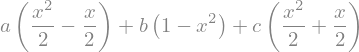

In [14]:
a, b, c = symbols('a b c')
abcpol = lagrangePolynomial([-1, 0, 1], [a, b, c])
abcpol

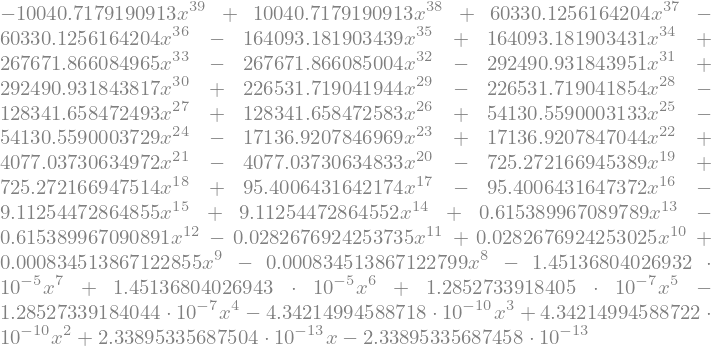

In [15]:
lag_pol(tuple(np.linspace(-1, 1, 40)), 0)

In [16]:
def phi_LGL(N, i):
    return lag_pol(tuple(LGL(N)), i)

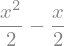

In [17]:
jj = phi_LGL(3,0)
jj

In [18]:
jj.evalf(subs = {x:1})

## Matrices de Derivación LGL

In [19]:
def matrix_D_1(N, precission):
    taus = LGL(N+1, precission)
    M = zeros(N+1)
    for i in range(N+1):
        func = phi_LGL(N+1, i).diff()
        for k in range(N+1):
            M[k, i] = func.evalf(n = precission, subs = {x:taus[k]})
    return M

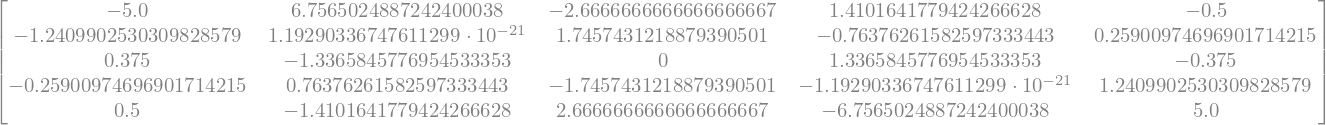

In [20]:
matrix_D_1(4, 20)

In [21]:
def matrix_D_2(N, precission):
    taus = LGL(N+1, precission)
    M = zeros(N+1)
    LN = legendre_poly(n = N, x=x)
    LN_t = [LN.evalf(n = precission, subs = {x:ii}) for ii in taus]
    for l in range(N+1):
        for k in range(N+1):
            if k != l :
                M[k,l] = LN_t[k]/(LN_t[l] * (taus[k]-taus[l]))
    M[0,0] = -N * (N+1)/4
    M[N,N] = N * (N+1)/4
    return M

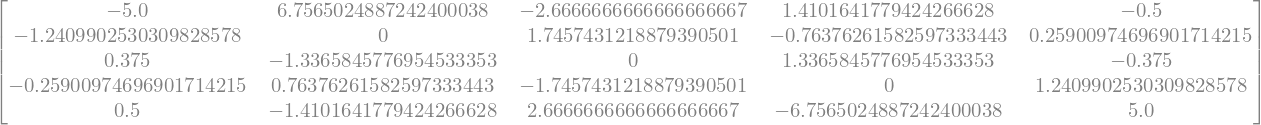

In [22]:
matrix_D_2(4, 20)

In [23]:
def LGL_abcpol(N, precission = 20):
    letters = [symbols(ii) for ii in 'abcdefghijklmnopqrsuvw']
    return lagrangePolynomial(LGL(N, precission), letters[:N])

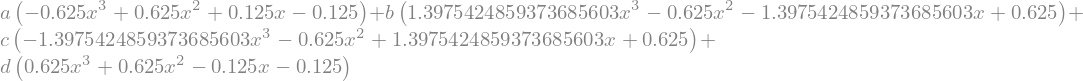

In [24]:
LGL_abcpol(4)

In [25]:
N = 4
letters = [symbols(ii) for ii in 'abcdefghijklmnopqrsuvw']
abcpoldiff = LGL_abcpol(N).diff(x)
for ii in LGL(N):
    print(abcpoldiff.evalf(n = 20, subs = {x:ii}))

-3.0*a + 4.0450849718747371205*b - 1.5450849718747371205*c + 0.5*d
-0.8090169943749474241*a - 1.6940658945086006781e-21*b + 1.1180339887498948482*c - 0.3090169943749474241*d
0.3090169943749474241*a - 1.1180339887498948482*b + 1.6940658945086006781e-21*c + 0.8090169943749474241*d
-0.5*a + 1.5450849718747371205*b - 4.0450849718747371205*c + 3.0*d


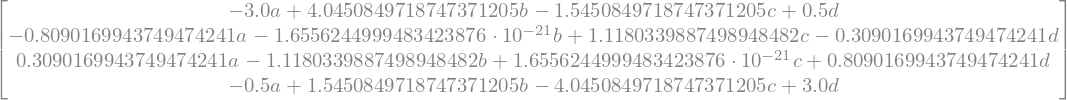

In [26]:
matrix_D_1(N-1,20)@Matrix(letters[:N])

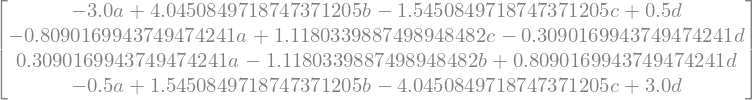

In [27]:
matrix_D_2(N-1,20)@Matrix(letters[:N])

In [28]:
abcpoldiff2 = abcpoldiff.diff(x)
for ii in LGL(N):
    print(abcpoldiff2.evalf(n = 20, subs = {x:ii}))

5.0*a - 9.6352549156242113615*b + 7.1352549156242113615*c - 2.5*d
2.9270509831248422723*a - 5.0*b + 2.5*c - 0.42705098312484227231*d
-0.42705098312484227231*a + 2.5*b - 5.0*c + 2.9270509831248422723*d
-2.5*a + 7.1352549156242113615*b - 9.6352549156242113615*c + 5.0*d


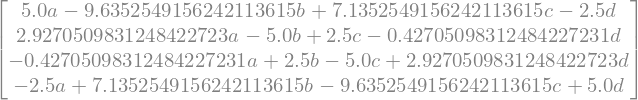

In [29]:
matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@Matrix(letters[:N])

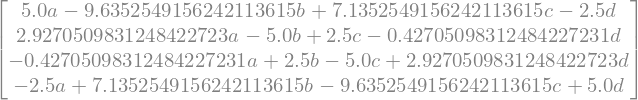

In [30]:
matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@Matrix(letters[:N])

In [31]:
abcpoldiff3 = abcpoldiff2.diff(x)
for ii in LGL(N):
    print(abcpoldiff3.evalf(n = 20, subs = {x:ii}))

-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d
-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d
-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d
-3.75*a + 8.3852549156242113615*b - 8.3852549156242113615*c + 3.75*d


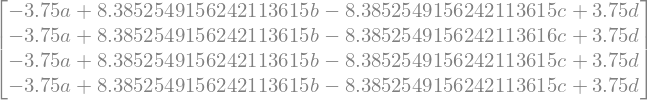

In [32]:
matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@Matrix(letters[:N])

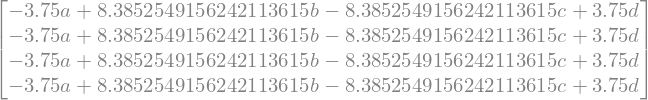

In [33]:
matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@Matrix(letters[:N])

In [34]:
abcpoldiff4 = abcpoldiff3.diff(x)
for ii in LGL(N):
    print(abcpoldiff4.evalf(n = 20, subs = {x:ii}))

0
0
0
0


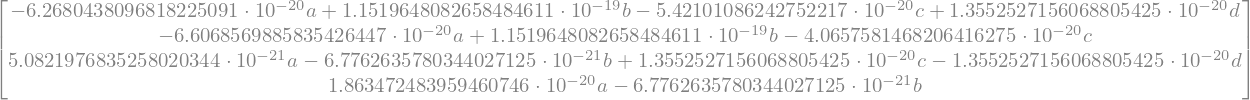

In [35]:
matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@matrix_D_1(N-1,20)@Matrix(letters[:N])

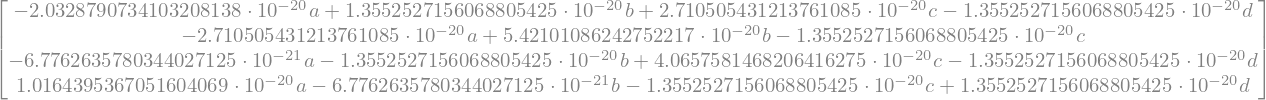

In [36]:
matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@matrix_D_2(N-1,20)@Matrix(letters[:N])

## Problema de ejemplo: bloque que desliza

$$\dot x_1 = x_2$$
$$\dot x_2 = u $$

Minimizar $t_f$ sujeto a:

$t_0 = 0\$

$x_2(0) = x_2(t_f) = 0$

$x_1(0) = 0\ ,\ x_1(t_f) = 1$

$ u_{min} < u(t) < u_{max}$

In [86]:
def error_transcr(pol_q, pol_v, pol_u, t0, t1):
    pol_q_dot = pol_q.diff(x)
    pol_v_dot = pol_v.diff(x)
    
    err_q_dot_pol = (pol_q_dot-pol_v)**2
    err_v_dot_pol = (pol_v_dot-pol_u)**2
    
    return err_q_dot_pol.integrate([x, t0, t1]) + err_q_dot_pol.integrate([x, t0, t1])

In [38]:
import casadi as cas

In [39]:
from optibot.casadi import sympy2casadi

In [40]:
import time

In [110]:
solve_repetitions = 30

#### LGL: función objetivo alternativa

$u(\tau)$ está definida como el polinomio de grado N-1 que pasa por los N valores calculados de $U^N$. Encontrar cómo obtener $\int_{-1}^{1}{u(\tau)^2}$ en función de $U^N$

In [87]:
def obj_f_u_LGL(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LGL(N, precission), coefs)
    res = integrate(pol_lag ** 2, [x, -1, 1])
    return lambdify(coefs, res)

In [88]:
def obj_f_u_LG2(N, precission = 20):
    coefs = symbols(f'c_0:{N}')
    pol_lag = lagrangePolynomial(LG(N, precission), coefs)
    res = integrate(pol_lag ** 2, [x, -1, 1])
    return lambdify(coefs, res)

### Formulación clásica $\dot x = f(x,u)$

In [89]:
x_sym = cas.SX.sym('x', 2)
x_dot_sym = cas.SX.sym('x_dot', 2)
u_sym = cas.SX.sym('u',1)

dynam_f = cas.Function(
    "dynamics",
    [x_sym, x_dot_sym, u_sym],
    [x_dot_sym[1]-u_sym]
)

In [105]:
N = 7
opti = cas.Opti()
opti.solver('ipopt')

In [106]:
x_opti = opti.variable(N, 2)
u_opti = opti.variable(N)
tau_arr = LGL(N, 20)
t_f = opti.variable(1)
t_0 = 0
u_lim = opti.parameter(1)

In [107]:
D_mat = sympy2casadi(matrix_D_2(N-1,20), [], [])
x_dot_opti = (2/t_f - t_0) * D_mat@x_opti

#cost = cas.sum1(u_opti**2)
#f_obj = obj_f_u_LGL(N)
#cost = f_obj(*cas.vertsplit(u_opti))
cost = t_f
opti.minimize(cost)

In [108]:
opti.subject_to(x_opti[0,:].T == [0., 0.])
opti.subject_to(x_opti[-1,:].T == [1. ,0.])
opti.subject_to(t_f > 0)

for ii in range(N):
    opti.subject_to(dynam_f(x_opti[ii,:], x_dot_opti[ii,:], u_opti[ii,:])==0)
    opti.subject_to(x_opti[ii,1] == x_dot_opti[ii,0])
    opti.subject_to(u_opti[ii] <= u_lim[0])
    opti.subject_to(-u_lim[0] <= u_opti[ii])

opti.set_value(u_lim, 1.)
opti.set_initial(t_f, 1.)

In [ ]:
cput0 = time.time()
for ii in range(solve_repetitions):
    sol = opti.solve()
cput1 = time.time()
cpudt_LGL = (cput1-cput0)/solve_repetitions

In [118]:
xx_sol_LGL = sol.value(x_opti)
uu_sol_LGL = sol.value(u_opti)
t_f_LGL = sol.value(t_f)

t_arr_LGL = t_0 + (1 + np.array(tau_arr))*(t_f_LGL - t_0)/2

q_pol_LGL = lagrangePolynomial(t_arr_LGL, xx_sol_LGL[:,0])
v_pol_LGL = lagrangePolynomial(t_arr_LGL, xx_sol_LGL[:,1])
u_pol_LGL = lagrangePolynomial(t_arr_LGL, uu_sol_LGL[:])

q_interp_f_LGL = lambdify([x,],q_pol_LGL)
v_interp_f_LGL = lambdify([x,],v_pol_LGL)
u_interp_f_LGL = lambdify([x,],u_pol_LGL)

In [119]:
t_arr_LGL

array([0.0, 0.17693728405263238630, 0.55355524036982750399,
       1.04218014298967, 1.5308050456095151378, 1.9074230019267102555,
       2.0843602859793426], dtype=object)

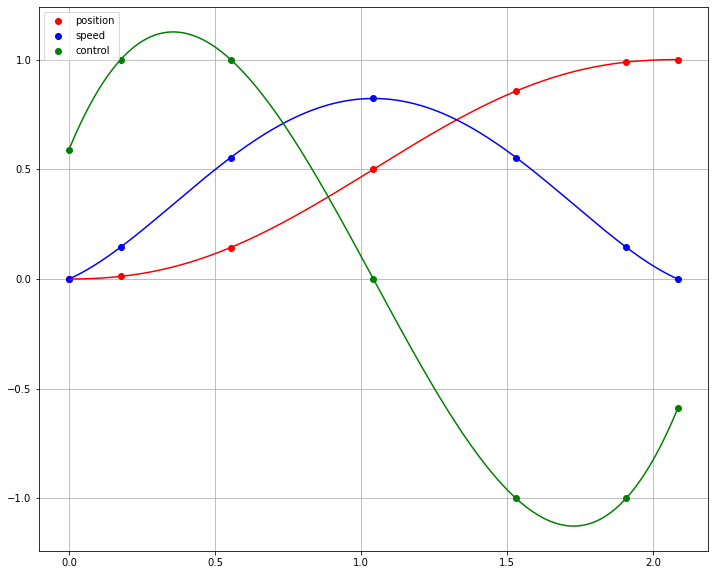

In [120]:
plt.figure(figsize=[12,10])
plt.plot(t_arr_LGL, xx_sol_LGL[:,0], 'ro', label = 'position')
plt.plot(t_arr_LGL, xx_sol_LGL[:,1], 'bo', label = 'speed')
plt.plot(t_arr_LGL, uu_sol_LGL[:], 'go', label = 'control')
N_interp = 300
t_int_arr_LGL = np.linspace(t_0, t_f_LGL, N_interp)
plt.plot(t_int_arr_LGL, q_interp_f_LGL(t_int_arr_LGL), 'r')
plt.plot(t_int_arr_LGL, v_interp_f_LGL(t_int_arr_LGL), 'b')
plt.plot(t_int_arr_LGL, u_interp_f_LGL(t_int_arr_LGL), 'g')
plt.grid()
plt.legend()

In [121]:
#u_sq_LGL = u_interp_f_LGL(t_int_arr)**2
#quality_LGL = np.trapz(u_sq_LGL, t_int_arr)
quality_LGL = t_f_LGL
quality_LGL

In [122]:
cpudt_LGL*1000

In [124]:
trun_err_LGL = error_transcr(q_pol_LGL, v_pol_LGL, u_pol_LGL, t_0, t_f_LGL)
trun_err_LGL

### Formulación $D^2$ de Ross, Rea y Fahroo

In [178]:
x_sym = cas.SX.sym('x', 1)
x_dot_sym = cas.SX.sym('x_dot', 1)
x_dot_dot_sym = cas.SX.sym('x_dot_dot', 1)
u_sym = cas.SX.sym('u',1)

dynam_f = cas.Function(
    "dynamics",
    [x_sym, x_dot_sym, x_dot_dot_sym, u_sym],
    [x_dot_dot_sym-u_sym]
)

In [179]:
N = 9
opti = cas.Opti()
opti.solver('ipopt')

In [180]:
x_opti = opti.variable(N)
u_opti = opti.variable(N)
tau_arr = LGL(N, 20)
t_f = opti.variable(1)
t_0 = 0
u_lim = opti.parameter(1)

In [181]:
D_mat = sympy2casadi(matrix_D_2(N-1,20), [], [])
x_dot_opti = (2/t_f - t_0) * D_mat@x_opti
x_dot_dot_opti = (2/t_f - t_0) * D_mat@x_dot_opti

#cost = cas.sum1(u_opti**2)
#f_obj = obj_f_u_LGL(N)
#cost = f_obj(*cas.vertsplit(u_opti))
cost = t_f
opti.minimize(cost)

In [182]:
opti.subject_to(x_opti[0] == [0.])
opti.subject_to(x_opti[-1] == [1.])
opti.subject_to(x_dot_opti[0] == [0.])
opti.subject_to(x_dot_opti[-1] == [0.])
opti.subject_to(t_f > 0)

for ii in range(N):
    opti.subject_to(dynam_f(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii,:])==0)
    opti.subject_to(u_opti[ii] <= u_lim[0])
    opti.subject_to(-u_lim[0] <= u_opti[ii])

opti.set_value(u_lim, 1.)
opti.set_initial(t_f, 1.)

In [ ]:
cput0 = time.time()
for ii in range(solve_repetitions):
    sol = opti.solve()
cput1 = time.time()
cpudt_D2 = (cput1-cput0)/solve_repetitions

In [184]:
xx_sol_D2 = sol.value(x_opti)
uu_sol_D2 = sol.value(u_opti)
vv_sol_D2 = sol.value(x_dot_opti)
t_f_D2 = sol.value(t_f)

t_arr_D2 = t_0 + (1 + np.array(tau_arr))*(t_f_D2 - t_0)/2

q_pol_D2 = lagrangePolynomial(t_arr_D2, xx_sol_D2[:])
v_pol_D2 = lagrangePolynomial(t_arr_D2, xx_sol_D2[:]).diff(x)
u_pol_D2 = lagrangePolynomial(t_arr_D2, uu_sol_D2[:])

q_interp_f_D2 = lambdify([x,],q_pol_D2)
v_interp_f_D2 = lambdify([x,],v_pol_D2)
u_interp_f_D2 = lambdify([x,],u_pol_D2)

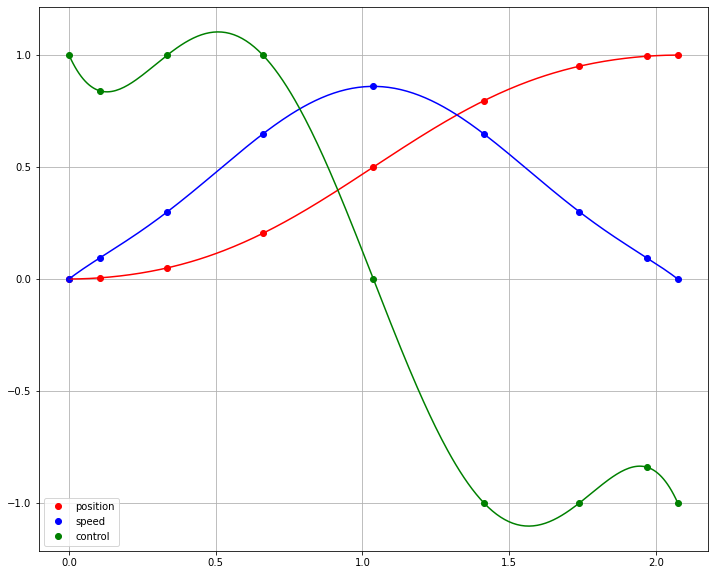

In [185]:
plt.figure(figsize=[12,10])
plt.plot(t_arr_D2, xx_sol_D2[:], 'ro', label = 'position')
plt.plot(t_arr_D2, vv_sol_D2[:], 'bo', label = 'speed')
plt.plot(t_arr_D2, uu_sol_D2[:], 'go', label = 'control')
N_interp = 300
t_int_arr_D2 = np.linspace(t_0, t_f_D2, N_interp)
plt.plot(t_int_arr_D2, q_interp_f_D2(t_int_arr_D2), 'r')
plt.plot(t_int_arr_D2, v_interp_f_D2(t_int_arr_D2), 'b')
plt.plot(t_int_arr_D2, u_interp_f_D2(t_int_arr_D2), 'g')
plt.grid()
plt.legend()

In [186]:
#u_sq_D2 = u_interp_f_D2(t_int_arr)**2
#quality_D2 = np.trapz(u_sq_D2, t_int_arr)
quality_D2 = t_f_D2
quality_D2

In [187]:
cpudt_D2*1000

In [188]:
trun_err_D2 = error_transcr(q_pol_D2, v_pol_D2, u_pol_D2, t_0, t_f_D2)
trun_err_D2

### Formulación nueva LG+2

In [66]:
def LG2(N, precission):
    return [-1]+LG(N-2, precission)+[1]

In [67]:
def phi_LG2(N, i, precission = 20):
    return lag_pol(tuple(LG2(N, precission)), i)

In [68]:
def matrix_D_LG2(N, precission):
    taus = LG2(N+1, precission)
    M = zeros(N+1)
    for i in range(N+1):
        func = phi_LG2(N+1, i).diff()
        for k in range(N+1):
            M[k, i] = func.evalf(n = precission, subs = {x:taus[k]})
    return M

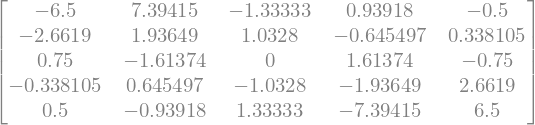

In [69]:
matrix_D_LG2(4,6)

In [70]:
def LG2_abcpol(N, precission = 20):
    letters = [symbols(ii) for ii in 'abcdefghijklmnopqrsuvw']
    return lagrangePolynomial(LG2(N, precission), letters[:N])

In [71]:
N=5
abcpoldiff = LG2_abcpol(N).diff(x)
for ii in LG2(N, 20):
    print(abcpoldiff.evalf(n = 20, subs = {x:ii}))

-6.5*a + 7.3941527885061807376*b - 1.3333333333333333333*c + 0.93918054482715259568*d - 0.5*e
-2.6618950038622250655*a + 1.9364916731037084426*b + 1.0327955589886445027*c - 0.64549722436790281419*d + 0.33810499613777493444*e
0.75*a - 1.6137430609197570355*b + 1.6137430609197570355*d - 0.75*e
-0.33810499613777493445*a + 0.64549722436790281419*b - 1.0327955589886445027*c - 1.9364916731037084426*d + 2.6618950038622250655*e
0.50000000000000000001*a - 0.93918054482715259568*b + 1.3333333333333333333*c - 7.3941527885061807376*d + 6.5*e


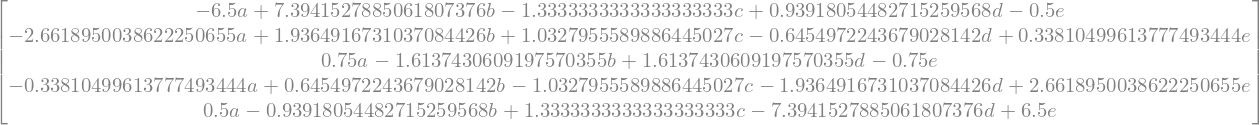

In [72]:
matrix_D_LG2(N-1,20)@Matrix(letters[:N])

Casadi:

In [141]:
x_sym = cas.SX.sym('x', 1)
x_dot_sym = cas.SX.sym('x_dot', 1)
x_dot_dot_sym = cas.SX.sym('x_dot_dot', 1)
u_sym = cas.SX.sym('u',1)

dynam_f = cas.Function(
    "dynamics",
    [x_sym, x_dot_sym, x_dot_dot_sym, u_sym],
    [x_dot_dot_sym-u_sym]
)

In [142]:
N = 7
opti = cas.Opti()
opti.solver('ipopt')

In [143]:
x_opti = opti.variable(N+2)
u_opti = opti.variable(N)
tau_arr_LG2 = LG2(N+2, 20)
t_f = opti.variable(1)
t_0 = 0
u_lim = opti.parameter(1)

In [144]:
D_mat = sympy2casadi(matrix_D_LG2(N+1,20), [], [])
x_dot_opti = (2/t_f - t_0) * D_mat@x_opti
x_dot_dot_opti = (2/t_f - t_0) * D_mat@x_dot_opti

#cost = cas.sum1(u_opti**2)
#f_obj = obj_f_u_LG2(N)
#cost = f_obj(*cas.vertsplit(u_opti))
cost = t_f
opti.minimize(cost)

In [145]:
opti.subject_to(x_opti[0] == [0.])
opti.subject_to(x_opti[-1] == [1.])
opti.subject_to(x_dot_opti[0] == [0.])
opti.subject_to(x_dot_opti[-1] == [0.])
opti.subject_to(t_f > 0)

for ii in range(1, N+1):
    opti.subject_to(dynam_f(x_opti[ii], x_dot_opti[ii], x_dot_dot_opti[ii], u_opti[ii-1,:])==0)
    opti.subject_to(u_opti[ii-1] <= u_lim[0])
    opti.subject_to(-u_lim[0] <= u_opti[ii-1])

opti.set_value(u_lim, 1.)
opti.set_initial(t_f, 1.)

In [ ]:
cput0 = time.time()
for ii in range(solve_repetitions):
    sol = opti.solve()
cput1 = time.time()
cpudt_LG2 = (cput1-cput0)/solve_repetitions

In [151]:
xx_sol_LG2 = sol.value(x_opti)
uu_sol_LG2 = sol.value(u_opti)
vv_sol_LG2 = sol.value(x_dot_opti)
t_f_LG2 = sol.value(t_f)

t_arr_LG2 = t_0 + (1 + np.array(tau_arr_LG2))*(t_f_D2 - t_0)/2
coll_p_t = t_0 + (1 + np.array(LG(N)))*(t_f_LG2 - t_0)/2

q_pol_LG2 = lagrangePolynomial(t_arr_LG2, xx_sol_LG2[:])
v_pol_LG2 = lagrangePolynomial(t_arr_LG2, xx_sol_LG2[:]).diff(x)
u_pol_LG2 = lagrangePolynomial(coll_p_t, uu_sol_LG2[:])

q_interp_f_LG2 = lambdify([x,],q_pol_LG2)
v_interp_f_LG2 = lambdify([x,],v_pol_LG2)
u_interp_f_LG2 = lambdify([x,],u_pol_LG2)

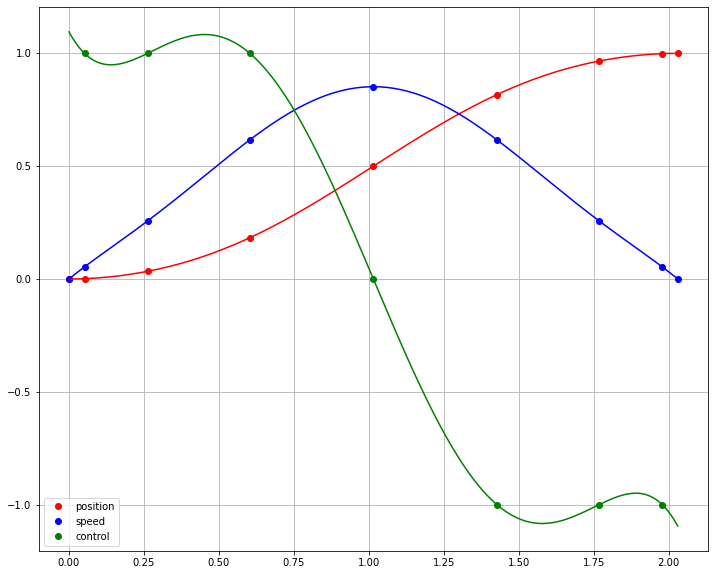

In [152]:
plt.figure(figsize=[12,10])
plt.plot(t_arr_LG2, xx_sol_LG2[:], 'ro', label = 'position')
plt.plot(t_arr_LG2, vv_sol_LG2[:], 'bo', label = 'speed')
plt.plot(coll_p_t, uu_sol_LG2[:], 'go', label = 'control')
N_interp = 300
t_int_arr_LG2 = np.linspace(t_0, t_f_LG2, N_interp)
plt.plot(t_int_arr_LG2, q_interp_f_LG2(t_int_arr_LG2), 'r')
plt.plot(t_int_arr_LG2, v_interp_f_LG2(t_int_arr_LG2), 'b')
plt.plot(t_int_arr_LG2, u_interp_f_LG2(t_int_arr_LG2), 'g')
plt.grid()
plt.legend()

In [153]:
#u_sq_LG2 = u_interp_f_LG2(t_int_arr)**2
#quality_LG2 = np.trapz(u_sq_LG2, t_int_arr)
quality_LG2 = t_f_LG2
quality_LG2

In [154]:
cpudt_LG2*1000

In [156]:
trun_err_LG2 = error_transcr(q_pol_LG2, v_pol_LG2, u_pol_LG2, t_0, t_f_LG2)
trun_err_LG2

## COMPARACIÓN DE RESULTADOS

In [189]:
from IPython.display import Markdown as md
md(f'''| | Usual LGL | $D^2$ | Nuevo LG2 |
| --- | --- | --- | --- |
| Coste a optimizar ($t_f$) | {round(quality_LGL,5)} | {round(quality_D2,5)} | {round(quality_LG2,5)} |
| Valor medio de $(U^N)^2$ | {round(np.mean(uu_sol_LGL**2),4)} | {round(np.mean(uu_sol_D2**2),4)} | {round(np.mean(uu_sol_LG2**2),4)} |
| CPU time (ms) | {round(cpudt_LGL*1000,4)} | {round(cpudt_D2*1000,4)} | {round(cpudt_LG2*1000,4)} |
| Integrated Truncation Error | {"{:.2e}".format(trun_err_LGL)} | {trun_err_D2} | {trun_err_LG2} |''')

| | Usual LGL | $D^2$ | Nuevo LG2 |
| --- | --- | --- | --- |
| Coste a optimizar ($t_f$) | 2.08436 | 2.0746 | 2.03013 |
| Valor medio de $(U^N)^2$ | 0.6709 | 0.8238 | 0.8571 |
| CPU time (ms) | 10.2129 | 12.4348 | 11.1983 |
| Integrated Truncation Error | 3.66e-22 | 0 | 0 |

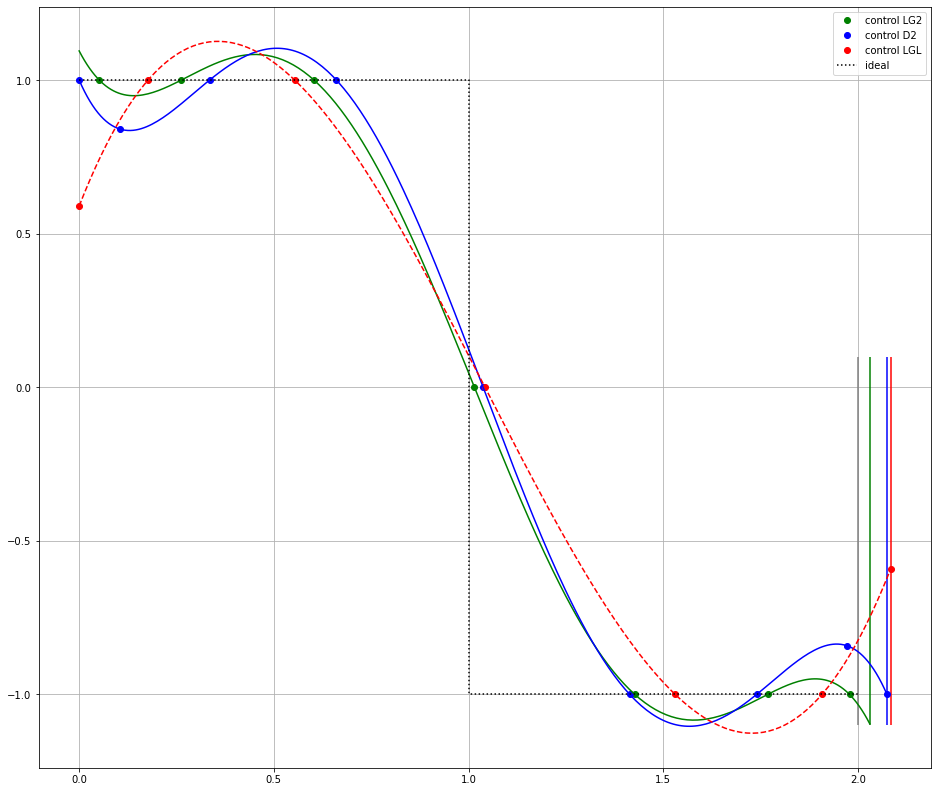

In [192]:
plt.figure(figsize=[16,14])

plt.plot(coll_p_t, uu_sol_LG2[:], 'go', label = 'control LG2')
plt.plot(t_arr_D2, uu_sol_D2[:], 'bo', label = 'control D2')
plt.plot(t_arr_LGL, uu_sol_LGL[:], 'ro', label = 'control LGL')

plt.plot(t_int_arr_LG2, u_interp_f_LG2(t_int_arr_LG2), 'g')
plt.plot(t_int_arr_D2, u_interp_f_D2(t_int_arr_D2), 'b')
plt.plot(t_int_arr_LGL, u_interp_f_LGL(t_int_arr_LGL), 'r--')
plt.plot([0,1,1,2], [1,1,-1,-1], 'k:', label = 'ideal')
plt.vlines([2, t_f_LGL, t_f_D2, t_f_LG2], -1.1, 0.1, colors=['gray', 'r', 'b', 'g'] )
plt.grid()
plt.legend()